## **Real-Time Face Emotion Detection**

- This project implements real-time facial emotion detection using the Deep CNN and OpenCV. It captures video from the webcam, detects faces, and predicts the emotions associated with each face. The emotion labels are displayed on the frames in real-time.
- Aims to classify the emotion on a person's face into one of seven categories, using deep convolutional neural networks.
- The dataset consists of 48x48 pixel grayscale images of faces. Each face is classified based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

**Approach**

1. Import the necessary libraries: cv2 for video capture and image processing, and CNN for the emotion detection model.

2. Load the Haar cascade classifier XML file for face detection using cv2.CascadeClassifier().

3. Start capturing video from the default webcam using cv2.VideoCapture().

4. Enter a continuous loop to process each frame of the captured video.

5. Convert each frame to grayscale using cv2.cvtColor().

6. Detect faces in the grayscale frame using face_cascade.detectMultiScale().

7. For each detected face, extract the face ROI (Region of Interest).

8. Preprocess the face image for emotion detection using the deepface library's built-in preprocessing function.

9. Make predictions for the emotions using the pre-trained emotion detection model provided by the deepface library.

10. Retrieve the index of the predicted emotion and map it to the corresponding emotion label.

11. Draw a rectangle around the detected face and label it with the predicted emotion using cv2.rectangle() and cv2.putText().

12. Display the resulting frame with the labeled emotion using cv2.imshow().

13. If the 'q' key is pressed, exit the loop.

14. Release the video capture and close all windows using cap.release() and cv2.destroyAllWindows().

In [36]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile

# Scikit-learn for machine learning metrics
from sklearn import metrics

# Tensorflow and keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model


# Set an option to display a maximum of 100 columns in Pandas DataFrame
pd.set_option('display.max_columns',100)

# Suppress warnings to improve the clarity of the output
warnings.filterwarnings('ignore')

In [3]:
# Mounting Google Drive to the Colab environment

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the path to the zip file containing the dataset
file_path = '/content/drive/MyDrive/Colab/archive.zip'

# directory where the extracted files will be saved
extract_dir = '/content/drive/MyDrive/Colab'

# Extracting files from the zip archive
with zipfile.ZipFile(file_path, 'r') as files:
  files.extractall(extract_dir)

In [5]:
# Define the directory containing the training and testing data.
train_data_dir = '/content/drive/MyDrive/Colab/train'
validation_data_dir = '/content/drive/MyDrive/Colab/test'

In [6]:
# ImageDataGenerator for augmenting training data

train_datagen = ImageDataGenerator(
    rescale=1./255,                         # Rescale pixel values to [0,1]
    rotation_range=30,                      # Random rotation up to 30 degrees
    shear_range=0.3,                        # Shear transformations
    zoom_range=0.3,                         # Random zoom
    horizontal_flip=True,                   # Random horizontal flips
    fill_mode='nearest'                     # Fill mode for newly created pixels
)

- Augmenting training data involves applying a variety of transformations to the original training images to artificially increase the size and diversity of the training dataset.
- The main purpose of data augmentation is to introduce variability into the training data, which helps the model become more robust and generalize better to unseen data.

In [7]:
# ImageDataGenerator for preprocessing validation data

validation_datagen = ImageDataGenerator(rescale=1./255)   # Rescale pixel values to [0,1]

In [8]:
# Creating a generator for training data

train_generator = train_datagen.flow_from_directory(
    train_data_dir,                                         #  Directory containing training images
    color_mode='grayscale',                                 # Color mode of the images
    target_size=(48, 48),                                   # Resizing images to (48, 48)
    batch_size=32,                                          
    class_mode='categorical',                               # Type of label assignment
    shuffle=True                                            # Shuffling the data
)   

Found 28704 images belonging to 7 classes.


In [9]:
# Creating a generator for testing data

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 7178 images belonging to 7 classes.


In [10]:
# Class labels corresponding to the emotion categories

class_labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Extracting an image and its label from the training generator
img, label = train_generator.__next__()

In [11]:
# Creating a sequential model
Model = Sequential()

# Adding a convolutional layer with 32 filters, each of size (3,3), using ReLU activation function
Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

Model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Adding max pooling layer with pool size (2,2) to down sample the feature maps
Model.add(MaxPooling2D(pool_size=(2, 2)))
# Adding dropout layer with a rate of 0.1 to prevent overfitting
Model.add(Dropout(0.1))                                             

Model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.1))

Model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.1))

# Flattening the feature 
Model.add(Flatten())

# Adding a fully connected layer with 512 neurons using ReLU activation function
Model.add(Dense(512, activation='relu'))
Model.add(Dropout(0.2))

# Adding the output layer with 7 neurons (corresponding to the 7 emotion classes) using softmax activation function
Model.add(Dense(7, activation='softmax'))

In [12]:
# Compiling the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Displaying the summary of the model architecture
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [14]:
# directory containing the training images
train_path = '/content/drive/MyDrive/Colab/train'

# Loop through the directory structure to count the number of training images
num_train_images = 0
for root, dirs, files in os.walk(train_path):
  num_train_images += len(files)

In [15]:
# directory containing the testing images
test_path = '/content/drive/MyDrive/Colab/test'

num_test_images = 0
for root, dir, files in os.walk(test_path):
  num_test_images += len(files)

In [16]:
print(f"Training Images: {num_train_images}")
print(f"Testing Images: {num_test_images}")

Training Images: 28704
Testing Images: 7178


In [17]:
# Train the model using the training generator
# steps_per_epoch is set to the total number of training images divided by the batch size
# validation_data is set to the validation generator
# validation_steps is set to the total number of validation images divided by the batch size
epochs = 40

history = Model.fit(train_generator,
                   steps_per_epoch=num_train_images//32,
                   epochs=epochs,
                   validation_data=validation_generator,
                   validation_steps=num_test_images//32)

Epoch 1/40
897/897 [==============================] - 191s 206ms/step - loss: 1.7701 - accuracy: 0.2683 - val_loss: 1.6912 - val_accuracy: 0.3150
Epoch 2/40
897/897 [==============================] - 148s 164ms/step - loss: 1.6592 - accuracy: 0.3336 - val_loss: 1.4728 - val_accuracy: 0.4328
Epoch 3/40
897/897 [==============================] - 129s 143ms/step - loss: 1.5155 - accuracy: 0.4092 - val_loss: 1.3430 - val_accuracy: 0.4891
Epoch 4/40
897/897 [==============================] - 133s 148ms/step - loss: 1.4311 - accuracy: 0.4480 - val_loss: 1.2783 - val_accuracy: 0.5133
Epoch 5/40
897/897 [==============================] - 128s 143ms/step - loss: 1.3768 - accuracy: 0.4722 - val_loss: 1.2269 - val_accuracy: 0.5339
Epoch 6/40
897/897 [==============================] - 125s 140ms/step - loss: 1.3357 - accuracy: 0.4909 - val_loss: 1.1999 - val_accuracy: 0.5445
Epoch 7/40
897/897 [==============================] - 125s 140ms/step - loss: 1.3032 - accuracy: 0.5035 - val_loss: 1.1779 -

In [23]:
# Save the trained Model

Model.save("Colab/Emotion_Detection_Model.h5")

In [27]:
# Load the Saved Model

loaded_model = load_model("/content/Colab/Emotion_Detection_Model.h5")

In [28]:
# Evaluate the model on the test dataset

evaluation = loaded_model.evaluate(validation_generator, steps=num_test_images//32)

224/224 [==============================] - 23s 101ms/step - loss: 1.0454 - accuracy: 0.6115


In [31]:
# Evaluation Results
print(f"Test Accuracy: {evaluation[1] * 100}")
print(f"Test Loss: {evaluation[0]}")

Test Accuracy: 61.14676594734192
Test Loss: 1.0454462766647339


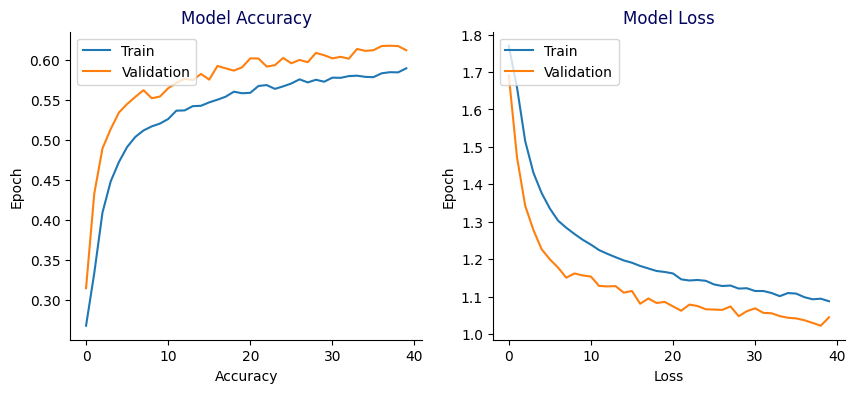

In [35]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontdict={'fontsize': 12, 'color': '#03045e'})
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontdict={'fontsize': 12, 'color': '#03045e'})
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')

sns.despine()
plt.show()